In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

In [195]:
df = pd.read_csv('Illinois_2021.csv', low_memory=False)

In [196]:
##################################################################################################

In [197]:
###### MODEL1: OUTPUT = APPLICATION STATUS ######

In [198]:
##### CLEANING #####

In [199]:
# DROPPING COLUMNS WITH NO VALUE
df.drop(['activity_year','state_code','census_tract','county_code','loan_type','derived_ethnicity',
         'derived_race','derived_sex', 'denial_reason-1','denial_reason-2','denial_reason-3','denial_reason-4',
         'applicant_age_above_62','co-applicant_age_above_62','tract_to_msa_income_percentage'], axis = 1, inplace = True)

In [200]:
# Filter the DF so that only accept or reject outcomes are present
df = df[df['action_taken'].isin([1,2,3])]

In [201]:
# Turning the Application outcome (action_taken) into dummy variables
df['action_taken'] = np.where((df['action_taken']==1)|(df['action_taken']==2),1,0)

In [202]:
# Filtering for only Home Purchase Loans
df = df[df['loan_purpose']==1]

In [203]:
# Filtering for only mortgage applications and NOT covered loans
df = df[df['submission_of_application']!=3]
df = df[df['initially_payable_to_institution']!=3]

In [204]:
# Dropping columns that are only applicable to succesful applications
df.drop(['interest_rate','rate_spread','purchaser_type','initially_payable_to_institution'], axis = 1, inplace = True)
df = df.reset_index(drop = True)

In [205]:
#### EXPLORING PROPERTY AND AREA RELATED FEATURES WITH SUCCESS RATE ###

In [206]:
### MSA CODE: 5 digit metropolitan statistical area or metropolitan division code: min 50K population

In [207]:
# MSA Code Success Rate 
msa = pd.DataFrame(df.groupby('derived_msa-md')['action_taken'].value_counts())
msa.columns = ['Count']
msa = msa.reset_index()
msa['%'] = 100 * msa['Count'] / msa.groupby('derived_msa-md')['Count'].transform('sum')
msa = msa.sort_values(['derived_msa-md', 'action_taken'], ascending = False).set_index(['derived_msa-md','action_taken'])
msa

Count          %
derived_msa-md action_taken                   
99999          1              15252  88.633194
               0               1956  11.366806
44100          1               4077  93.337912
               0                291   6.662088
41180          1              12384  91.910346
               0               1090   8.089654
40420          1               5378  91.665246
               0                489   8.334754
37900          1               7671  94.575268
               0                440   5.424732
29404          1              13288  93.268758
               0                959   6.731242
28100          1               1728  87.582362
               0                245  12.417638
20994          1              14637  93.610898
               0                999   6.389102
19500          1               1645  89.743590
               0                188  10.256410
19340          1               3641  92.340857
               0                302   7.659143
19180          1                781  87.851519
               0                108  12.148481
16984          1             114186  91.603090
               0              10467   8.396910
16580          1               3359  92.867017
               0                258   7.132983
16060          1               1661  86.963351
               0                249  13.036649
16020          1                 18  45.000000
               0                 22  55.000000
14010          1               3191  90.937589
               0                318   9.062411
0              1                411  26.481959
               0               1141  73.518041

In [208]:
# NEW FEATURE: In MSA 16984 or not in 16984: are houses within (Chicago, Naperville, Evanston) more succesful?
itopmsa = pd.DataFrame(df[['derived_msa-md','action_taken']])
itopmsa['intopmsa'] = ''
itopmsa['intopmsa'] = np.where(itopmsa['derived_msa-md']!= 16984,0,1)
itopmsa = itopmsa.drop('derived_msa-md',axis = 1)
# Comparison of overall success %
topmsa = pd.DataFrame(itopmsa.groupby('intopmsa')['action_taken'].value_counts())
topmsa.columns = ['Count']
topmsa = topmsa.reset_index()
topmsa['%'] = 100 * topmsa['Count'] / topmsa.groupby('intopmsa')['Count'].transform('sum')
topmsa = topmsa.sort_values(['intopmsa', 'action_taken'], ascending = False).set_index(['intopmsa','action_taken'])
topmsa

Count          %
intopmsa action_taken                   
1        1             114186  91.603090
         0              10467   8.396910
0        1              89122  90.776862
         0               9055   9.223138

Text(0.5, 1.0, 'Success vs Rejection for 16580 MSA code or not')

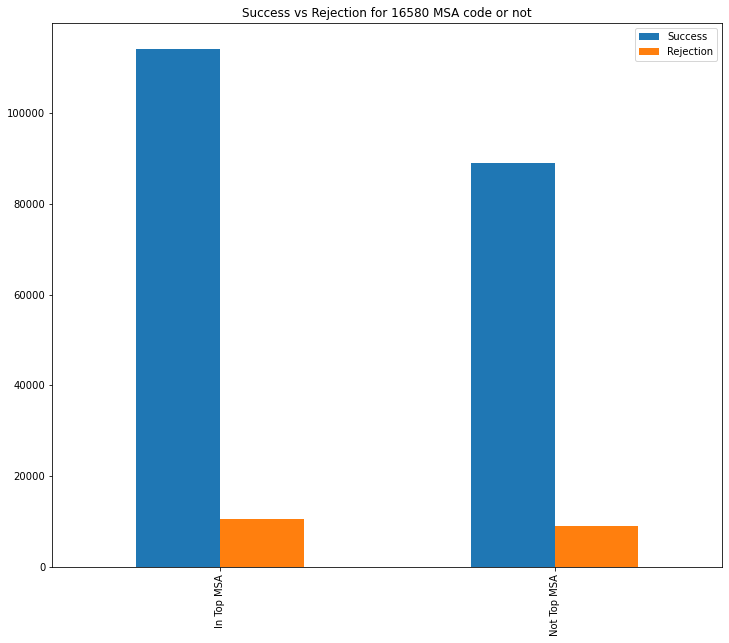

In [210]:
# Comparing Not 16580 vs 16580 Success Rates: graph
graph_topmsa = pd.concat([pd.DataFrame([itopmsa.groupby('intopmsa')['action_taken'].value_counts()[1][1],itopmsa.groupby('intopmsa')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([itopmsa.groupby('intopmsa')['action_taken'].value_counts()[0][1],itopmsa.groupby('intopmsa')['action_taken'].value_counts()[0][0]]).transpose()])
graph_topmsa.index = ['In Top MSA','Not Top MSA']
graph_topmsa.columns = ['Success','Rejection']

graph_topmsa.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for 16580 MSA code or not")

In [211]:
# HYPOTHESIS TESTING : IN TOP MSA > SUCCESS THAN NOT?
population = topmsa.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['In Top MSA %','Not Top MSA %','PVal']
testresult.index = ['']
testresult

,In Top MSA %,Not Top MSA %,PVal
,91.603,90.777,0.000000


In [212]:
### Occupancy Type: 1 is principal residence, 2 is secondary, 3 is investment

In [213]:
# distribution of occupancy type applications
df['occupancy_type'].value_counts()

1    203233
3     16370
2      3227
Name: occupancy_type, dtype: int64

In [214]:
# Occupancy Type + Success Rate
ot = pd.DataFrame(df.groupby('occupancy_type')['action_taken'].value_counts())
ot.columns = ['Count']
ot = ot.reset_index()
ot['%'] = 100 * ot['Count'] / ot.groupby('occupancy_type')['Count'].transform('sum')
ot = ot.sort_values(['occupancy_type', 'action_taken'], ascending = False).set_index(['occupancy_type','action_taken'])
ot

Count          %
occupancy_type action_taken                   
3              1              15036  91.850947
               0               1334   8.149053
2              1               2941  91.137279
               0                286   8.862721
1              1             185331  91.191391
               0              17902   8.808609

Text(0.5, 1.0, 'Success vs Rejection for Occupancy Types')

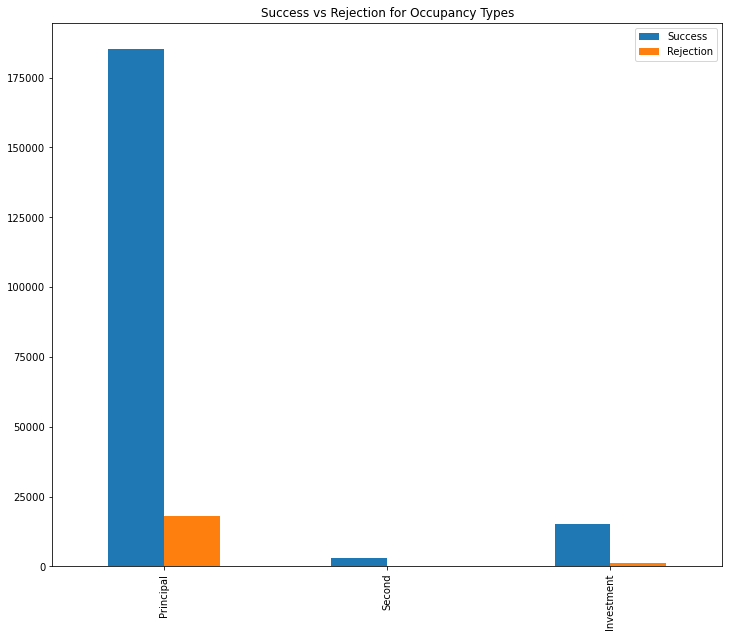

In [215]:
# Comparing Occupancy Type 1-2-3  Success Rates
# Comparing Occupancy Type Success Rates: graph
graph_ot = pd.concat([pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[1][1],df.groupby('occupancy_type')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[2][1],df.groupby('occupancy_type')['action_taken'].value_counts()[2][0]]).transpose(),
           pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[3][1],df.groupby('occupancy_type')['action_taken'].value_counts()[3][0]]).transpose()])

graph_ot.index = ['Principal','Second','Investment']
graph_ot.columns = ['Success','Rejection']

graph_ot.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Occupancy Types")

In [271]:
# HYPOTHESIS TESTING : Occupancy Type impact on success?
population = ot.reset_index()

testresult = pd.DataFrame()
testresult['Investment %'] = list([round(population.iloc[0][3],3)]) 
testresult['Second %'] = list([round(population.iloc[2][3],3)])
testresult['Principal %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Investment vs Second','Investment vs Principal', 'Second vs Principal']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Investment %,Second %,Principal %,Investment vs Second,Investment vs Principal,Second vs Principal
,91.851,91.137,91.191,0.198648,0.005934,0.918182


In [217]:
## PROPERTY VALUE ##

In [232]:
# DROP ALL THAT HAVE AN EXEMPT / NOT NUMERIC
numeric_value = pd.DataFrame(df['action_taken'])
numeric_value['property_value'] = pd.to_numeric(df['property_value'], errors='coerce')
numeric_value = numeric_value.dropna().reset_index(drop = True)
len(df)-len(numeric_value)

10038

In [249]:
# Creating Buckets for Property Values
low = numeric_value['property_value'].quantile(.33)
medium = numeric_value['property_value'].quantile(.66)
numeric_value['Value_Bracket'] = np.where(numeric_value['property_value']<=low,'Low',
         np.where((numeric_value['property_value']>low)&(numeric_value['property_value']<medium),'Medium',
                 np.where(numeric_value['property_value']>=medium,'High','ERROR')))

print('Low: Property Value <=',low)
print('Medium: Property Value >',low,'and <',medium)
print('High: Property Value >=',medium)

Low: Property Value <= 195000.0
Medium: Property Value > 195000.0 and < 325000.0
High: Property Value >= 325000.0


In [251]:
# Value Bracket + Success Rate
vb = pd.DataFrame(numeric_value.groupby('Value_Bracket')['action_taken'].value_counts())
vb.columns = ['Count']
vb = vb.reset_index()
vb['%'] = 100 * vb['Count'] / vb.groupby('Value_Bracket')['Count'].transform('sum')
vb = vb.sort_values(['Value_Bracket', 'action_taken'], ascending = False).set_index(['Value_Bracket','action_taken'])
vb

Count          %
Value_Bracket action_taken                  
Medium        1             58305  92.419991
              0              4782   7.580009
Low           1             65899  88.154480
              0              8855  11.845520
High          1             70971  94.689864
              0              3980   5.310136

Text(0.5, 1.0, 'Success vs Rejection for Property Value Bracket')

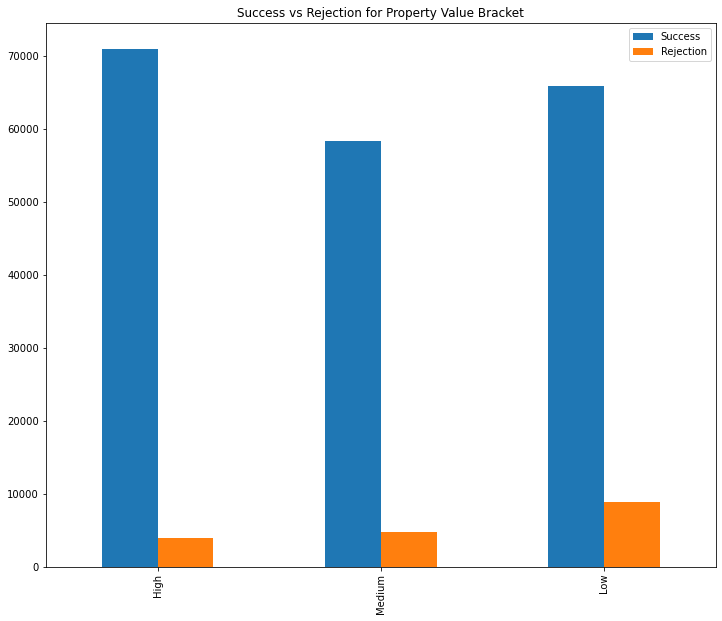

In [264]:
# Comparing Value Brackets Property Success Rates
graph_vb = pd.concat([pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['High'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_vb.index = ['High','Medium','Low']
graph_vb.columns = ['Success','Rejection']

graph_vb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Property Value Bracket")

In [272]:
# HYPOTHESIS TESTING : Property Value Brackets impact on success?
population = vb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.42,88.154,94.69,0.000000,0.000000,0.000000


In [273]:
# TRACT POPULATION #

In [277]:
# Creating Buckets for Tract population
tract = pd.DataFrame(df[['tract_population','action_taken']])

low = tract['tract_population'].quantile(.33)
medium = tract['tract_population'].quantile(.66)
tract['Population_Bracket'] = np.where(tract['tract_population']<=low,'Low',
         np.where((tract['tract_population']>low)&(tract['tract_population']<medium),'Medium',
                 np.where(tract['tract_population']>=medium,'High','ERROR')))

print('Low: Population <=',low)
print('Medium: Population >',low,'and <',medium)
print('High: Population >=',medium)

Low: Population <= 4019.0
Medium: Population > 4019.0 and < 5626.0
High: Population >= 5626.0


In [278]:
# Population Bracket + Success Rate
pb = pd.DataFrame(tract.groupby('Population_Bracket')['action_taken'].value_counts())
pb.columns = ['Count']
pb = pb.reset_index()
pb['%'] = 100 * pb['Count'] / pb.groupby('Population_Bracket')['Count'].transform('sum')
pb = pb.sort_values(['Population_Bracket', 'action_taken'], ascending = False).set_index(['Population_Bracket','action_taken'])
pb

Count          %
Population_Bracket action_taken                  
Medium             1             67504  91.989861
                   0              5878   8.010139
Low                1             65768  89.271365
                   0              7904  10.728635
High               1             70036  92.425042
                   0              5740   7.574958

Text(0.5, 1.0, 'Success vs Rejection for Population Bracket')

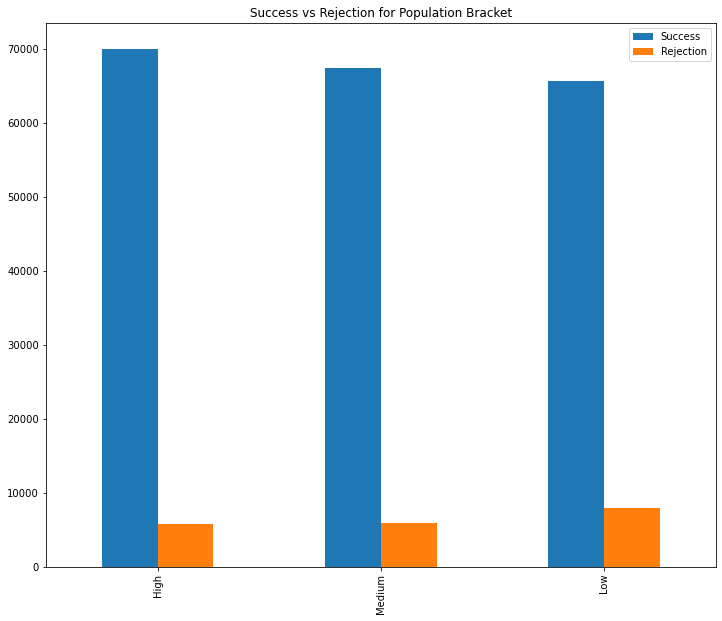

In [279]:
# Comparing Population Success Rates
graph_pb = pd.concat([pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['High'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['Medium'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['Low'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_pb.index = ['High','Medium','Low']
graph_pb.columns = ['Success','Rejection']

graph_pb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Population Bracket")

In [280]:
# HYPOTHESIS TESTING : Population impact on success?
population = pb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,91.99,89.271,92.425,0.000000,0.002607,0.000000


In [281]:
# Tract Minority Population #

In [294]:
# Creating Buckets for Minority %
minority_tract = pd.DataFrame(df[['tract_minority_population_percent','action_taken']])

low = minority_tract['tract_minority_population_percent'].quantile(.33)
medium = minority_tract['tract_minority_population_percent'].quantile(.66)
minority_tract['Minority_Population_Bracket'] = np.where(minority_tract['tract_minority_population_percent']<=low,'Low',
         np.where((minority_tract['tract_minority_population_percent']>low)&(minority_tract['tract_minority_population_percent']<medium),'Medium',
                 np.where(minority_tract['tract_minority_population_percent']>=medium,'High','ERROR')))

print('Low: Minority Percent <=',low)
print('Medium: Minority Percent >',low,'and <',medium)
print('High: Minority Percent >=',medium)

Low: Minority Percent <= 15.11
Medium: Minority Percent > 15.11 and < 33.84
High: Minority Percent >= 33.84


In [288]:
# Minority % + Success Rate
mpb = pd.DataFrame(minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts())
mpb.columns = ['Count']
mpb = mpb.reset_index()
mpb['%'] = 100 * mpb['Count'] / mpb.groupby('Minority_Population_Bracket')['Count'].transform('sum')
mpb = mpb.sort_values(['Minority_Population_Bracket', 'action_taken'], ascending = False).set_index(['Minority_Population_Bracket','action_taken'])
mpb

Count          %
Minority_Population_Bracket action_taken                  
Medium                      1             68375  93.090538
                            0              5075   6.909462
Low                         1             67059  91.125153
                            0              6531   8.874847
High                        1             67874  89.555350
                            0              7916  10.444650

Text(0.5, 1.0, 'Success vs Rejection for Minority Population Bracket')

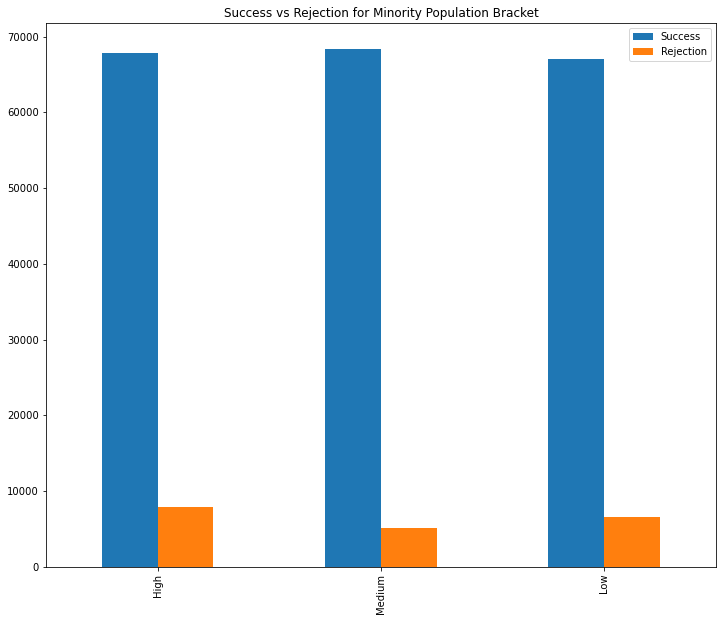

In [289]:
# Comparing Minority % Brackets Success Rates
graph_mpb = pd.concat([pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['High'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Medium'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Low'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_mpb.index = ['High','Medium','Low']
graph_mpb.columns = ['Success','Rejection']

graph_mpb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Minority Population Bracket")

In [290]:
# HYPOTHESIS TESTING : Minority % Brackets impact on success?
population = mpb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,93.091,91.125,89.555,0.000000,0.000000,0.000000


In [306]:
#### EXPLORING APPLICANT RELATED FEATURES WITH SUCCESS RATE ###

In [ ]:
# Income #

In [309]:
# DROP ALL THAT HAVE A NOT NUMERIC INCOME
numeric_income = pd.DataFrame(df['action_taken'])
numeric_income['income'] = pd.to_numeric(df['income'], errors='coerce')
numeric_income = numeric_income.dropna().reset_index(drop = True)
len(df)-len(numeric_income)

7563

In [310]:
# Creating Buckets for Income 
low = numeric_income['income'].quantile(.33)
medium = numeric_income['income'].quantile(.66)
numeric_income['Income_Bracket'] = np.where(numeric_income['income']<=low,'Low',
         np.where((numeric_income['income']>low)&(numeric_income['income']<medium),'Medium',
                 np.where(numeric_income['income']>=medium,'High','ERROR')))

print('Low: Income <=',low)
print('Medium: Income >',low,'and <',medium)
print('High: Income >=',medium)

Low: Income <= 62.0
Medium: Income > 62.0 and < 106.0
High: Income >= 106.0


In [312]:
# Income Bracket + Success Rate
ib = pd.DataFrame(numeric_income.groupby('Income_Bracket')['action_taken'].value_counts())
ib.columns = ['Count']
ib = ib.reset_index()
ib['%'] = 100 * ib['Count'] / ib.groupby('Income_Bracket')['Count'].transform('sum')
ib = ib.sort_values(['Income_Bracket', 'action_taken'], ascending = False).set_index(['Income_Bracket','action_taken'])
ib

Count          %
Income_Bracket action_taken                  
Medium         1             63654  92.621317
               0              5071   7.378683
Low            1             62195  85.970005
               0             10150  14.029995
High           1             70600  95.152095
               0              3597   4.847905

Text(0.5, 1.0, 'Success vs Rejection for Income Bracket')

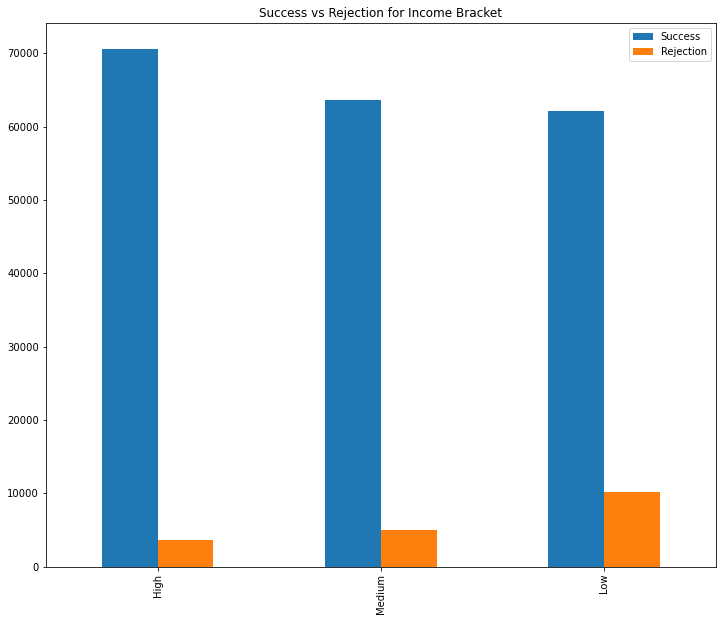

In [315]:
# Comparing Income Brackets Property Success Rates
graph_ib = pd.concat([pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['High'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Low'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_ib.index = ['High','Medium','Low']
graph_ib.columns = ['Success','Rejection']

graph_ib.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Income Bracket")

In [314]:
# HYPOTHESIS TESTING : Income Brackets impact on success?
population = ib.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult


,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.621,85.97,95.152,0.000000,0.000000,0.000000


In [ ]:
# Debt to Income #

In [316]:
# CLEANING UP DEBT TO INCOME!
test=pd.DataFrame(np.where(df['debt_to_income_ratio'].str.contains('%',na = False),df['debt_to_income_ratio'],
        np.where((~df['debt_to_income_ratio'].str.contains('%',na = False))&(~df['debt_to_income_ratio'].str.contains('Exempt',na = False))&(~df['debt_to_income_ratio'].isnull()),'50%-60%',df['debt_to_income_ratio'])))
df['debt_to_income_ratio'] = test

124815

In [374]:
# DROP ALL THAT HAVE AN EXEMPT / blank
numeric_dti = pd.DataFrame(df[['action_taken','debt_to_income_ratio']])
numeric_dti['debt_to_income_ratio'] = np.where(numeric_dti['debt_to_income_ratio']=='Exempt',np.nan,numeric_dti['debt_to_income_ratio'])
numeric_dti = numeric_dti.dropna().reset_index(drop = True)
len(df) - len(numeric_dti)

14028

In [375]:
# DTI Bracket + Success Rate
dti = pd.DataFrame(numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts())
dti.columns = ['Count']
dti = dti.reset_index()
dti['%'] = 100 * dti['Count'] / dti.groupby('debt_to_income_ratio')['Count'].transform('sum')
dti = dti.sort_values(['debt_to_income_ratio', 'action_taken'], ascending = False).set_index(['debt_to_income_ratio','action_taken'])
dti

Count          %
debt_to_income_ratio action_taken                   
>60%                 1                366   9.546166
                     0               3468  90.453834
<20%                 1              12456  87.842031
                     0               1724  12.157969
50%-60%              1             102761  92.291457
                     0               8583   7.708543
30%-<36%             1              36004  95.228523
                     0               1804   4.771477
20%-<30%             1              39520  94.917860
                     0               2116   5.082140

Text(0.5, 1.0, 'Success vs Rejection for DTI Bracket')

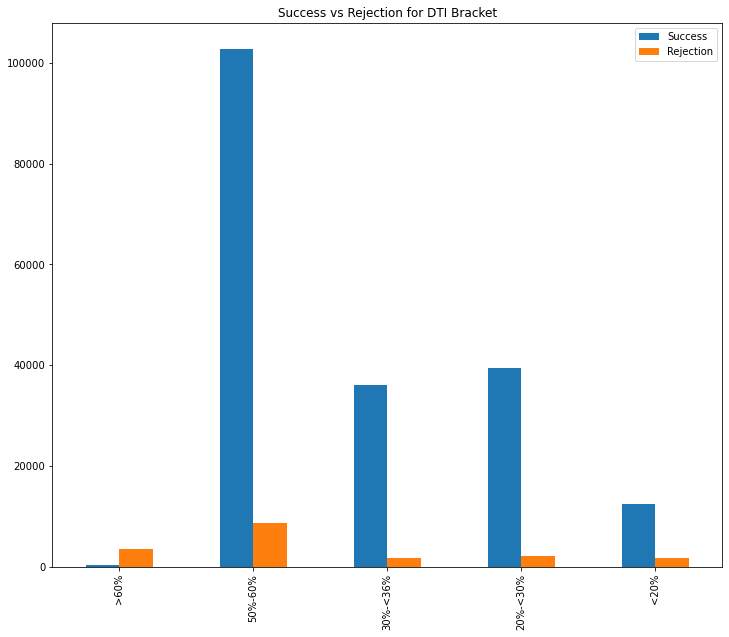

In [376]:
# Comparing DTI Brackets Property Success Rates
graph_dti = pd.concat([pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['>60%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['>60%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['50%-60%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['50%-60%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['30%-<36%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['30%-<36%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['20%-<30%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['20%-<30%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['<20%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['<20%'][0]]).transpose()])

graph_dti.index = ['>60%','50%-60%','30%-<36%','20%-<30%','<20%']
graph_dti.columns = ['Success','Rejection']

graph_dti.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for DTI Bracket")

In [380]:
# HYPOTHESIS TESTING : DTI Brackets impact on success?
population = dti.reset_index()

testresult = pd.DataFrame()
testresult['>60% %'] = list([round(population.iloc[0][3],3)]) 
testresult['<20% %'] = list([round(population.iloc[2][3],3)])
testresult['50%-60% %'] = list([round(population.iloc[4][3],3)])
testresult['30%-<36% %'] = list([round(population.iloc[6][3],3)])
testresult['20%-<30% %'] = list([round(population.iloc[8][3],3)])

columnnames = ['>60 vs <20','>60 vs 50-60', '>60 vs 30-36','>60 vs 20-30','<20 vs 50-60',
              '<20 vs 30-36','<20 vs 20-30','50-60 vs 30-36','50-60 vs 20-30','30-36 vs 20-30']

sample1_phat_list = [0,0,0,0,2,2,2,4,4,6,3,3,3,3,3,3,3,3,3,3]
sample2_phat_list = [2,4,6,8,4,6,8,6,8,8,3,3,3,3,3,3,3,3,3,3]
sample1_size_list = [0,0,0,0,2,2,2,4,4,6,2,2,2,2,2,2,2,2,2,2]
sample2_size_list = [2,4,6,8,4,6,8,6,8,8,2,2,2,2,2,2,2,2,2,2]


for x in range(len(population)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+10]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+10]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+10]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+10]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,>60% %,<20% %,50%-60% %,30%-<36% %,20%-<30% %,>60 vs <20,>60 vs 50-60,>60 vs 30-36,>60 vs 20-30,<20 vs 50-60,<20 vs 30-36,<20 vs 20-30,50-60 vs 30-36,50-60 vs 20-30,30-36 vs 20-30
,9.546,87.842,92.291,95.229,94.918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048968


In [381]:
# Ethnicity #

In [391]:
# CREATING A NEW FIELD: SAME ETHNICITY BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_ethnicity'] = np.where(df['applicant_ethnicity-1']==df['co-applicant_ethnicity-1'],1,0)

# ANALYZING HISPANIC/LATINO VS NOT
hispanic_latino = pd.DataFrame(df['action_taken'])
hispanic_latino['Ethnicity'] = np.where(df['applicant_ethnicity-1']==1,1,np.where(df['applicant_ethnicity-1']==2,0,np.nan))
hispanic_latino = hispanic_latino.dropna().reset_index(drop = True)

In [392]:
# Hispanic/Latino vs not + Success Rate
hl = pd.DataFrame(hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts())
hl.columns = ['Count']
hl = hl.reset_index()
hl['%'] = 100 * hl['Count'] / hl.groupby('Ethnicity')['Count'].transform('sum')
hl = hl.sort_values(['Ethnicity', 'action_taken'], ascending = False).set_index(['Ethnicity','action_taken'])
hl

Count          %
Ethnicity action_taken                   
1.0       1              27118  89.430465
          0               3205  10.569535
0.0       1             150042  92.059343
          0              12942   7.940657

Text(0.5, 1.0, 'Success vs Rejection for Hispanic/Latino or Not')

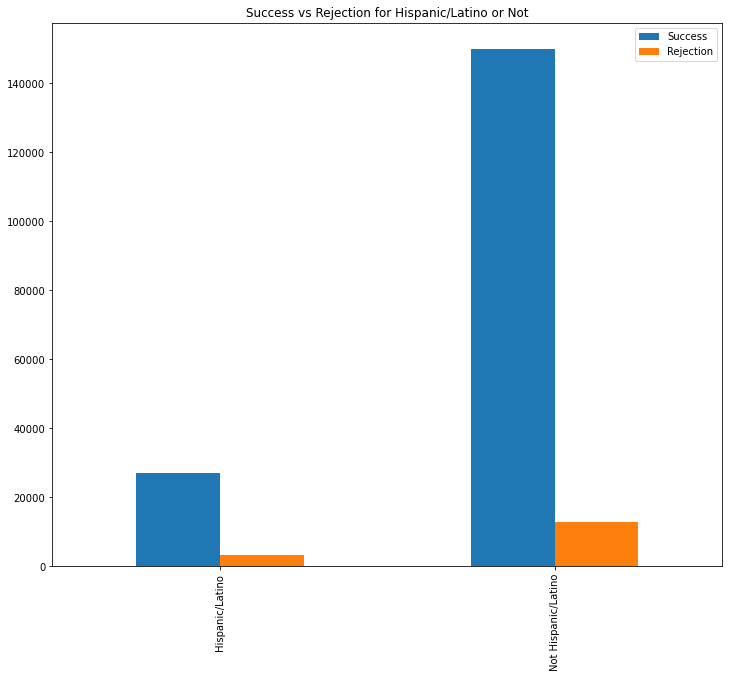

In [393]:
# Comparing Hispanic/Latino vs not Success Rates
graph_hs = pd.concat([pd.DataFrame([hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[1][1],hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[0][1],hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[0][0]]).transpose()])
graph_hs.index = ['Hispanic/Latino','Not Hispanic/Latino']
graph_hs.columns = ['Success','Rejection']

graph_hs.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Hispanic/Latino or Not")

In [399]:
# HYPOTHESIS TESTING : IN Hispanic/Latino vs Not
population = hl.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Hispanic or Latino %','Not Hispanic or Latino %','PVal']
testresult.index = ['']
testresult

,Hispanic or Latino %,Not Hispanic or Latino %,PVal
,89.43,92.059,0.000000


In [400]:
# Race #

In [416]:
# CREATING A NEW FIELD: SAME RACE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_race'] = np.where(df['applicant_race-1']==df['co-applicant_race-1'],1,0)

# ANALYZING ONLY BLACK, ASIAN, WHITE (TOP 3)
top3_race = pd.DataFrame(df['action_taken'])
top3_race['Race'] = np.where(df['applicant_race-1']==5,'White',np.where(df['applicant_race-1']==3,'Black',
                                                                        np.where(df['applicant_race-1']==2,'Asian',np.nan)))
top3_race = top3_race.dropna().reset_index(drop = True)
top3_race = top3_race[top3_race['Race']!='nan']

In [418]:
# Top 3 Race + Success Rate
t3r = pd.DataFrame(top3_race.groupby('Race')['action_taken'].value_counts())
t3r.columns = ['Count']
t3r = t3r.reset_index()
t3r['%'] = 100 * t3r['Count'] / t3r.groupby('Race')['Count'].transform('sum')
t3r = t3r.sort_values(['Race', 'action_taken'], ascending = False).set_index(['Race','action_taken'])
t3r

Count          %
Race  action_taken                   
White 1             141639  92.903010
      0              10820   7.096990
Black 1              17990  81.628023
      0               4049  18.371977
Asian 1              13614  93.599175
      0                931   6.400825

Text(0.5, 1.0, 'Success vs Rejection for Top 3 Races')

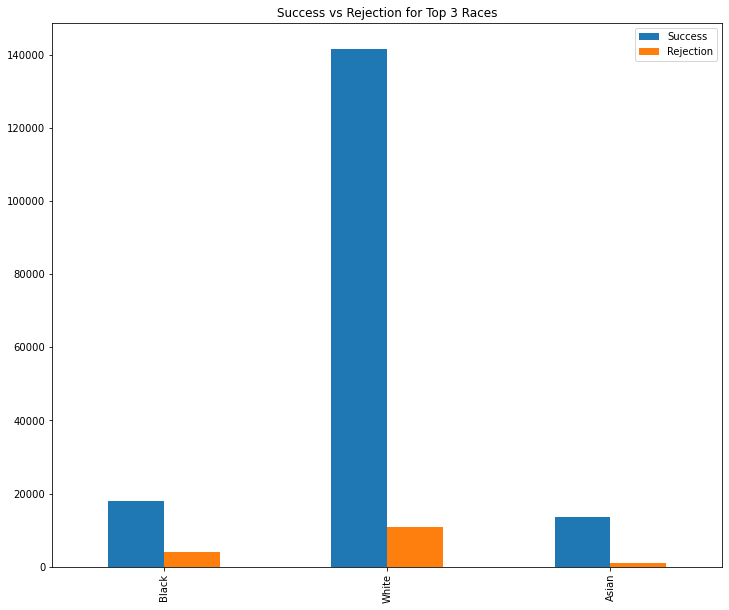

In [419]:
# Comparing Value Brackets Property Success Rates
graph_t3r = pd.concat([pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['Black'][1],top3_race.groupby('Race')['action_taken'].value_counts()['Black'][0]]).transpose(),
           pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['White'][1],top3_race.groupby('Race')['action_taken'].value_counts()['White'][0]]).transpose(),
           pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['Asian'][1],top3_race.groupby('Race')['action_taken'].value_counts()['Asian'][0]]).transpose()])
graph_t3r.index = ['Black','White','Asian']
graph_t3r.columns = ['Success','Rejection']

graph_t3r.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Top 3 Races")

In [422]:
# HYPOTHESIS TESTING : Top 3 Races impact on success?
population = t3r.reset_index()

testresult = pd.DataFrame()
testresult['White %'] = list([round(population.iloc[0][3],3)]) 
testresult['Black %'] = list([round(population.iloc[2][3],3)])
testresult['Asian %'] = list([round(population.iloc[4][3],3)])

columnnames = ['White vs Black','White vs Asian', 'Black vs Asian']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,White %,Black %,Asian %,White vs Black,White vs Asian,Black vs Asian
,92.903,81.628,93.599,0.000000,0.002417,0.000000


In [423]:
# SEX #

In [431]:
# CREATING A NEW FIELD: SAME RACE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_sex'] = np.where(df['applicant_sex']==df['co-applicant_sex'],1,0)

# ANALYZING Male and Female: Applicant
male_female = pd.DataFrame(df['action_taken'])
male_female['Sex'] = np.where(df['applicant_sex']==1,'Male',np.where(df['applicant_sex']==2,'Female',np.nan))
male_female = male_female.dropna().reset_index(drop = True)
male_female = male_female[male_female['Sex']!='nan']

In [433]:
# Sex + Success Rate
sex = pd.DataFrame(male_female.groupby('Sex')['action_taken'].value_counts())
sex.columns = ['Count']
sex = sex.reset_index()
sex['%'] = 100 * sex['Count'] / sex.groupby('Sex')['Count'].transform('sum')
sex = sex.sort_values(['Sex', 'action_taken'], ascending = False).set_index(['Sex','action_taken'])
sex

Count          %
Sex    action_taken                   
Male   1             117941  92.078821
       0              10146   7.921179
Female 1              72555  90.174122
       0               7906   9.825878

Text(0.5, 1.0, 'Success vs Rejection for Male vs Female')

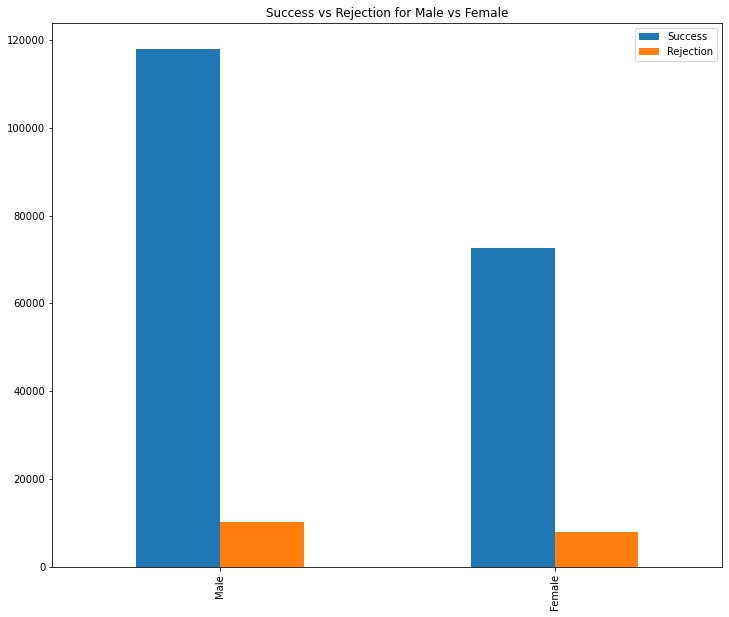

In [435]:
# Comparing Hispanic/Latino vs not Success Rates
graph_sex = pd.concat([pd.DataFrame([male_female.groupby('Sex')['action_taken'].value_counts()['Male'][1],male_female.groupby('Sex')['action_taken'].value_counts()['Male'][0]]).transpose(),
           pd.DataFrame([male_female.groupby('Sex')['action_taken'].value_counts()['Female'][1],male_female.groupby('Sex')['action_taken'].value_counts()['Female'][0]]).transpose()])
graph_sex.index = ['Male','Female']
graph_sex.columns = ['Success','Rejection']

graph_sex.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Male vs Female")

In [436]:
# HYPOTHESIS TESTING : SEX and Success
population = sex.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Male %','Female %','PVal']
testresult.index = ['']
testresult

,Male %,Female %,PVal
,92.079,90.174,0.000000


In [ ]:
# AGE #

In [444]:
# CREATING A NEW FIELD: SAME AGE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_age'] = np.where(df['applicant_age']==df['co-applicant_age'],1,0)

age_bracket = df[df['applicant_age']!='8888'][['action_taken','applicant_age']]

In [445]:
# Age Bracket + Success Rate
age = pd.DataFrame(age_bracket.groupby('applicant_age')['action_taken'].value_counts())
age.columns = ['Count']
age = age.reset_index()
age['%'] = 100 * age['Count'] / age.groupby('applicant_age')['Count'].transform('sum')
age = age.sort_values(['applicant_age', 'action_taken'], ascending = False).set_index(['applicant_age','action_taken'])
age

Count          %
applicant_age action_taken                  
>74           1              2301  91.237113
              0               221   8.762887
<25           1             12120  89.078348
              0              1486  10.921652
65-74         1              9030  91.138474
              0               878   8.861526
55-64         1             19208  89.740235
              0              2196  10.259765
45-54         1             32112  89.876571
              0              3617  10.123429
35-44         1             55859  91.498632
              0              5190   8.501368
25-34         1             67847  92.508965
              0              5494   7.491035

In [448]:
# NEW AGE BRACKET
new_age = pd.DataFrame(df['action_taken'])
new_age['Age'] = np.where((df['applicant_age']=='25-34')|(df['applicant_age']=='35-44'),1,0)

In [451]:
# age + Success Rate
age = pd.DataFrame(new_age.groupby('Age')['action_taken'].value_counts())
age.columns = ['Count']
age = age.reset_index()
age['%'] = 100 * age['Count'] / age.groupby('Age')['Count'].transform('sum')
age = age.sort_values(['Age', 'action_taken'], ascending = False).set_index(['Age','action_taken'])
age

Count          %
Age action_taken                   
1   1             123706  92.050004
    0              10684   7.949996
0   1              79602  90.006784
    0               8838   9.993216

Text(0.5, 1.0, 'Success vs Rejection for within 25-44 or not')

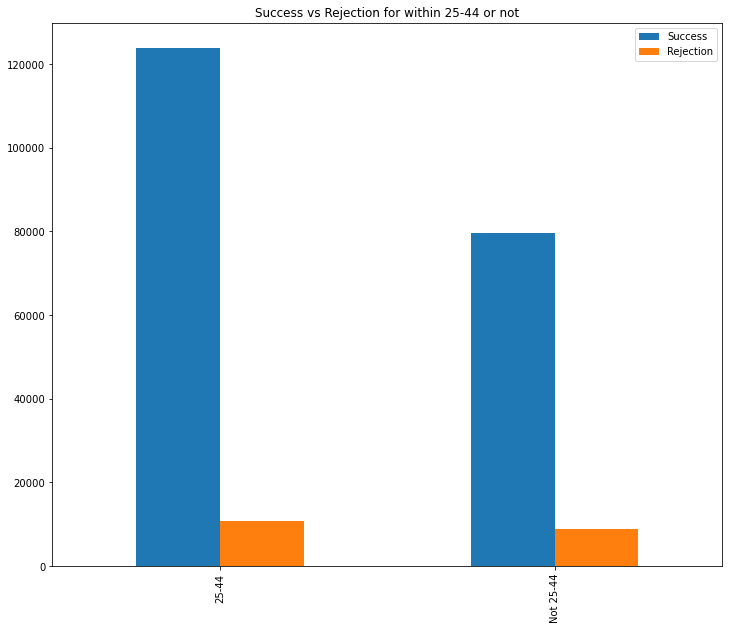

In [453]:
# Comparing Age and Success Rates
graph_age = pd.concat([pd.DataFrame([new_age.groupby('Age')['action_taken'].value_counts()[1][1],new_age.groupby('Age')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([new_age.groupby('Age')['action_taken'].value_counts()[0][1],new_age.groupby('Age')['action_taken'].value_counts()[0][0]]).transpose()])
graph_age.index = ['25-44','Not 25-44']
graph_age.columns = ['Success','Rejection']

graph_age.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for within 25-44 or not")

In [454]:
# HYPOTHESIS TESTING : Age and Success
population = age.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['25-44 %','Not 25-44 %','PVal']
testresult.index = ['']
testresult

,25-44 %,Not 25-44 %,PVal
,92.05,90.007,0.000000
